In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo
from IPython.display import display, clear_output
from time import sleep
from glob import glob
from pathlib import Path
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-19 00:51:20,890	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# env config
import gymnasium as gym
import platoonenv

env_name = "Platoon-v5"
env_config=dict(
    num_vehicles=10,
    steps_before_truncation=200,
    cycle_interval=1,
    cycle_num=1,
    attack_interval=1,
)
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config,
)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v5 
------------------
reward_threshold None
max_episode_steps None


In [4]:
from ray.rllib.utils import check_env

check_env(env)

2023-01-19 00:51:24,438	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.random_agent import RandomAgentConfig

ppo_config = (
    PPOConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=1, num_cpus_for_local_worker=0.5)
)

ppo_config.horizon = env.spec.max_episode_steps
ppo_config.create_env_on_local_worker=True

dqn_config = (
    DQNConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
dqn_config.horizon = env.spec.max_episode_steps
dqn_config.create_env_on_local_worker=True

random_config = (
    RandomAgentConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
random_config.horizon = env.spec.max_episode_steps
random_config.create_env_on_local_worker=True

In [6]:
ppo_algo = ppo_config.build()

(RolloutWorker pid=6632) 2023-01-19 00:51:34,355	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=6632) 2023-01-19 00:51:34,355	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=12636) 2023-01-19 00:51:34,401	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=2604) 2023-01-19 00:51:34,492	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=2604) 2023-01-19 00:51:34,493	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=12636) 2023-01-19 00:51:34,443	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=12636) 2023-01-19 00:51:34,443	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
2023-01-19 00:51:34,549	INFO policy.py:1196 -- Policy (worker

In [7]:
!ray status

======== Autoscaler status: 2023-01-19 00:51:35.106117 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_99c0d7abbe3dee5e57f40a8c71fce72ae42577c0a9d511d4c477f772
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 3.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/10.949 GiB memory
 0.00/5.475 GiB object_store_memory

Demands:
 (no resource demands)


In [8]:
dqn_algo = dqn_config.build()

(RolloutWorker pid=9268) 2023-01-19 00:51:49,161	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-01-19 00:51:49,296	INFO policy.py:1196 -- Policy (worker=local) running on 0.5 GPUs.
2023-01-19 00:51:49,297	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=9268) 2023-01-19 00:51:49,221	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=9268) 2023-01-19 00:51:49,221	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=14748) 2023-01-19 00:51:49,223	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=14748) 2023-01-19 00:51:49,223	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
2023-01-19 00:51:49,328	INFO rollout_worker.py:2037 -- Built policy map: <PolicyMap lru-caching-capacity=100 pol

In [9]:
!ray status

======== Autoscaler status: 2023-01-19 00:51:50.133925 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_99c0d7abbe3dee5e57f40a8c71fce72ae42577c0a9d511d4c477f772
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 6.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/10.949 GiB memory
 0.00/5.475 GiB object_store_memory

Demands:
 (no resource demands)


In [10]:
random_algo = random_config.build()

In [11]:
!ray status

======== Autoscaler status: 2023-01-19 00:51:55.151873 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_99c0d7abbe3dee5e57f40a8c71fce72ae42577c0a9d511d4c477f772
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 6.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/10.949 GiB memory
 0.00/5.475 GiB object_store_memory

Demands:
 (no resource demands)


In [12]:
checkpoints = sorted(glob(str(Path("saved_models","**","checkpoint_*"))))

In [13]:
import ipywidgets as widgets

In [14]:
ppo_save_dir = Path("saved_models",f"{env_name}-{str(ppo_algo)}-{env_config['num_vehicles']}vehicles")
ppo_save_dir.mkdir(parents=True, exist_ok=True)
print(ppo_save_dir)

ppo_checkpoint_path = sorted(glob(str(ppo_save_dir / "*")))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=ppo_checkpoint_path,
    description='PPO:'
)

def on_change(change):
    global ppo_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        ppo_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v5-PPO-10vehicles


Dropdown(description='PPO:', index=52, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curi…

In [15]:
dqn_save_dir = Path("saved_models",f"{env_name}-{str(dqn_algo)}-{env_config['num_vehicles']}vehicles")
dqn_save_dir.mkdir(parents=True, exist_ok=True)
print(dqn_save_dir)

dqn_checkpoint_path = sorted(glob(str(dqn_save_dir / "*")))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=dqn_checkpoint_path,
    description='DQN:'
)

def on_change(change):
    global dqn_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        dqn_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v5-DQN-10vehicles


Dropdown(description='DQN:', index=44, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curi…

In [16]:
print(f"PPO restoring from checkpoint: {ppo_checkpoint_path}")
ppo_algo.restore(ppo_checkpoint_path)

2023-01-19 00:51:55,921	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v5-PPO-10vehicles\checkpoint_001044
2023-01-19 00:51:55,922	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 1044, '_timesteps_total': None, '_time_total': 20095.526886463165, '_episodes_total': 20760}


PPO restoring from checkpoint: saved_models\Platoon-v5-PPO-10vehicles\checkpoint_001044


In [17]:
{k:v for k,v in ppo_algo.get_state().items() if k != "last_result"}

{'experiment_id': 'e36f74bd41624b5a826ea1a9d59b9d4a',
 'iteration': 1044,
 'timesteps_total': None,
 'time_total': 20095.526886463165,
 'episodes_total': 20760,
 'ray_version': '3.0.0.dev0'}

In [18]:
print(f"DQN restoring from checkpoint: {dqn_checkpoint_path}")
dqn_algo.restore(dqn_checkpoint_path)

DQN restoring from checkpoint: saved_models\Platoon-v5-DQN-10vehicles\checkpoint_001000


2023-01-19 00:51:56,048	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v5-DQN-10vehicles\checkpoint_001000
2023-01-19 00:51:56,048	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 5725.466508626938, '_episodes_total': 4970}


In [19]:
{k:v for k,v in dqn_algo.get_state().items() if k != "last_result"}

{'experiment_id': '65684c93838d45b7a0e60afff48233e7',
 'iteration': 1000,
 'timesteps_total': None,
 'time_total': 5725.466508626938,
 'episodes_total': 4970,
 'ray_version': '3.0.0.dev0'}

In [20]:
import numpy as np

In [21]:
%matplotlib ipympl

In [35]:
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config={
        **env_config,
        "steps_before_truncation": 200
    },
)
num_episodes = 100

In [36]:
policies = {
    "ppo": lambda obs: ppo_algo.compute_single_action(obs, explore=True),
    "dqn": lambda obs: dqn_algo.compute_single_action(obs, explore=True),
    "random": lambda obs: env.action_space.sample(),
}

In [53]:
results = {}

In [54]:
with tqdm(total=env_config["steps_before_truncation"]*len(policies)*num_episodes) as pbar:
    for policy_name, policy in policies.items():
        pbar.set_description(policy_name)
        actions = []
        rewards = []
        observations = []
        for episode in range(num_episodes):
            obs, info = env.reset(seed=episode)
            observations.append((obs,info))
            for episode_step in count():
                pbar.update()
                action = policy(obs=obs)
                next_obs, reward, terminated, truncated, info = env.step(action)
                actions.append(action)
                rewards.append(float(reward))
                observations.append((next_obs,info))
                if terminated or truncated:
                    print(f"trained ended after step {episode_step} with reward {sum(rewards):.2f} (spec: {env.spec.reward_threshold})")
                    break
                obs = next_obs
        results[policy_name] = {
            "actions": actions,
            "rewards": rewards,
            "observations": observations,
        }


ppo:   0%|          | 251/60000 [00:00<03:52, 256.88it/s]

trained ended after step 200 with reward -2.10 (spec: None)


ppo:   1%|          | 450/60000 [00:01<03:27, 287.64it/s]

trained ended after step 200 with reward -3.99 (spec: None)


ppo:   1%|          | 678/60000 [00:02<02:40, 368.79it/s]

trained ended after step 200 with reward -6.07 (spec: None)


ppo:   1%|▏         | 873/60000 [00:02<02:47, 352.56it/s]

trained ended after step 200 with reward -8.13 (spec: None)


ppo:   2%|▏         | 1066/60000 [00:03<03:12, 305.44it/s]

trained ended after step 200 with reward -10.20 (spec: None)


ppo:   2%|▏         | 1252/60000 [00:03<02:45, 355.75it/s]

trained ended after step 200 with reward -12.10 (spec: None)


ppo:   2%|▏         | 1478/60000 [00:04<02:44, 356.23it/s]

trained ended after step 200 with reward -14.10 (spec: None)


ppo:   3%|▎         | 1646/60000 [00:05<03:13, 301.59it/s]

trained ended after step 200 with reward -16.15 (spec: None)


ppo:   3%|▎         | 1865/60000 [00:05<02:59, 323.53it/s]

trained ended after step 200 with reward -18.23 (spec: None)


ppo:   3%|▎         | 2042/60000 [00:06<03:23, 284.52it/s]

trained ended after step 200 with reward -20.16 (spec: None)


ppo:   4%|▎         | 2219/60000 [00:07<02:51, 336.51it/s]

trained ended after step 200 with reward -22.17 (spec: None)


ppo:   4%|▍         | 2460/60000 [00:07<02:54, 330.54it/s]

trained ended after step 200 with reward -24.35 (spec: None)


ppo:   4%|▍         | 2652/60000 [00:08<03:17, 290.96it/s]

trained ended after step 200 with reward -26.26 (spec: None)


ppo:   5%|▍         | 2881/60000 [00:09<03:05, 307.35it/s]

trained ended after step 200 with reward -28.44 (spec: None)


ppo:   5%|▌         | 3052/60000 [00:09<02:58, 318.68it/s]

trained ended after step 200 with reward -30.47 (spec: None)


ppo:   5%|▌         | 3287/60000 [00:10<02:46, 341.13it/s]

trained ended after step 200 with reward -32.55 (spec: None)


ppo:   6%|▌         | 3455/60000 [00:11<02:24, 392.44it/s]

trained ended after step 200 with reward -34.73 (spec: None)


ppo:   6%|▌         | 3653/60000 [00:11<02:31, 372.68it/s]

trained ended after step 200 with reward -36.83 (spec: None)


ppo:   6%|▋         | 3873/60000 [00:12<02:49, 331.12it/s]

trained ended after step 200 with reward -38.92 (spec: None)


ppo:   7%|▋         | 4052/60000 [00:12<03:20, 278.40it/s]

trained ended after step 200 with reward -40.85 (spec: None)


ppo:   7%|▋         | 4287/60000 [00:13<02:53, 321.60it/s]

trained ended after step 200 with reward -42.76 (spec: None)


ppo:   7%|▋         | 4478/60000 [00:14<02:33, 362.26it/s]

trained ended after step 200 with reward -45.03 (spec: None)


ppo:   8%|▊         | 4673/60000 [00:14<02:47, 329.77it/s]

trained ended after step 200 with reward -47.02 (spec: None)


ppo:   8%|▊         | 4864/60000 [00:15<03:01, 303.57it/s]

trained ended after step 200 with reward -48.98 (spec: None)


ppo:   8%|▊         | 5048/60000 [00:15<02:36, 350.14it/s]

trained ended after step 200 with reward -50.84 (spec: None)


ppo:   9%|▉         | 5252/60000 [00:16<02:55, 312.27it/s]

trained ended after step 200 with reward -52.78 (spec: None)


ppo:   9%|▉         | 5497/60000 [00:17<02:38, 343.54it/s]

trained ended after step 200 with reward -54.93 (spec: None)


ppo:   9%|▉         | 5682/60000 [00:18<02:40, 338.13it/s]

trained ended after step 200 with reward -56.84 (spec: None)


ppo:  10%|▉         | 5917/60000 [00:18<02:40, 336.30it/s]

trained ended after step 200 with reward -58.80 (spec: None)


ppo:  10%|█         | 6034/60000 [00:19<02:27, 365.86it/s]

trained ended after step 200 with reward -60.88 (spec: None)


ppo:  10%|█         | 6299/60000 [00:19<02:31, 354.47it/s]

trained ended after step 200 with reward -62.84 (spec: None)


ppo:  11%|█         | 6481/60000 [00:20<02:43, 327.11it/s]

trained ended after step 200 with reward -64.95 (spec: None)


ppo:  11%|█         | 6692/60000 [00:21<02:56, 302.40it/s]

trained ended after step 200 with reward -67.00 (spec: None)


ppo:  12%|█▏        | 6906/60000 [00:21<02:33, 346.75it/s]

trained ended after step 200 with reward -68.98 (spec: None)


ppo:  12%|█▏        | 7078/60000 [00:22<03:10, 278.02it/s]

trained ended after step 200 with reward -71.03 (spec: None)


ppo:  12%|█▏        | 7270/60000 [00:23<02:49, 310.98it/s]

trained ended after step 200 with reward -73.24 (spec: None)


ppo:  13%|█▎        | 7506/60000 [00:23<02:38, 331.95it/s]

trained ended after step 200 with reward -75.23 (spec: None)


ppo:  13%|█▎        | 7687/60000 [00:24<02:42, 322.35it/s]

trained ended after step 200 with reward -77.25 (spec: None)


ppo:  13%|█▎        | 7897/60000 [00:25<02:46, 312.34it/s]

trained ended after step 200 with reward -79.25 (spec: None)


ppo:  14%|█▎        | 8102/60000 [00:26<02:41, 321.96it/s]

trained ended after step 200 with reward -81.31 (spec: None)


ppo:  14%|█▍        | 8283/60000 [00:26<02:37, 329.21it/s]

trained ended after step 200 with reward -83.39 (spec: None)


ppo:  14%|█▍        | 8493/60000 [00:27<02:30, 343.21it/s]

trained ended after step 200 with reward -85.55 (spec: None)


ppo:  15%|█▍        | 8715/60000 [00:27<02:24, 355.79it/s]

trained ended after step 200 with reward -87.52 (spec: None)


ppo:  15%|█▍        | 8908/60000 [00:28<02:32, 334.86it/s]

trained ended after step 200 with reward -89.50 (spec: None)


ppo:  15%|█▌        | 9092/60000 [00:29<02:59, 283.03it/s]

trained ended after step 200 with reward -91.45 (spec: None)


ppo:  16%|█▌        | 9307/60000 [00:29<02:29, 339.72it/s]

trained ended after step 200 with reward -93.58 (spec: None)


ppo:  16%|█▌        | 9492/60000 [00:30<02:22, 353.46it/s]

trained ended after step 200 with reward -95.63 (spec: None)


ppo:  16%|█▌        | 9683/60000 [00:30<02:25, 346.46it/s]

trained ended after step 200 with reward -97.69 (spec: None)


ppo:  17%|█▋        | 9911/60000 [00:31<02:32, 328.88it/s]

trained ended after step 200 with reward -99.58 (spec: None)


ppo:  17%|█▋        | 10093/60000 [00:32<02:45, 301.46it/s]

trained ended after step 200 with reward -101.45 (spec: None)


ppo:  17%|█▋        | 10312/60000 [00:32<02:18, 357.85it/s]

trained ended after step 200 with reward -103.35 (spec: None)


ppo:  17%|█▋        | 10493/60000 [00:33<02:35, 317.72it/s]

trained ended after step 200 with reward -105.23 (spec: None)


ppo:  18%|█▊        | 10695/60000 [00:34<02:43, 301.54it/s]

trained ended after step 200 with reward -107.21 (spec: None)


ppo:  18%|█▊        | 10880/60000 [00:34<03:07, 261.86it/s]

trained ended after step 200 with reward -109.18 (spec: None)


ppo:  18%|█▊        | 11067/60000 [00:35<02:41, 303.29it/s]

trained ended after step 200 with reward -111.27 (spec: None)


ppo:  19%|█▉        | 11298/60000 [00:35<02:13, 366.11it/s]

trained ended after step 200 with reward -113.34 (spec: None)


ppo:  19%|█▉        | 11512/60000 [00:36<02:25, 332.48it/s]

trained ended after step 200 with reward -115.46 (spec: None)


ppo:  19%|█▉        | 11693/60000 [00:37<02:27, 327.17it/s]

trained ended after step 200 with reward -117.48 (spec: None)


ppo:  20%|█▉        | 11895/60000 [00:37<02:19, 345.27it/s]

trained ended after step 200 with reward -119.58 (spec: None)


ppo:  20%|██        | 12120/60000 [00:38<02:11, 363.16it/s]

trained ended after step 200 with reward -121.71 (spec: None)


ppo:  20%|██        | 12298/60000 [00:39<02:25, 328.06it/s]

trained ended after step 200 with reward -123.67 (spec: None)


ppo:  21%|██        | 12515/60000 [00:39<02:27, 321.33it/s]

trained ended after step 200 with reward -125.65 (spec: None)


ppo:  21%|██        | 12726/60000 [00:40<02:31, 311.47it/s]

trained ended after step 200 with reward -127.73 (spec: None)


ppo:  22%|██▏       | 12902/60000 [00:41<02:52, 272.42it/s]

trained ended after step 200 with reward -129.82 (spec: None)


ppo:  22%|██▏       | 13103/60000 [00:41<02:36, 299.67it/s]

trained ended after step 200 with reward -131.89 (spec: None)


ppo:  22%|██▏       | 13311/60000 [00:42<02:20, 332.72it/s]

trained ended after step 200 with reward -133.94 (spec: None)


ppo:  23%|██▎       | 13519/60000 [00:43<02:20, 331.83it/s]

trained ended after step 200 with reward -135.87 (spec: None)


ppo:  23%|██▎       | 13727/60000 [00:43<02:25, 318.24it/s]

trained ended after step 200 with reward -137.87 (spec: None)


ppo:  23%|██▎       | 13922/60000 [00:44<02:58, 257.76it/s]

trained ended after step 200 with reward -140.00 (spec: None)


ppo:  23%|██▎       | 14089/60000 [00:45<02:52, 265.64it/s]

trained ended after step 200 with reward -141.96 (spec: None)


ppo:  24%|██▍       | 14313/60000 [00:45<02:06, 361.45it/s]

trained ended after step 200 with reward -143.94 (spec: None)


ppo:  24%|██▍       | 14548/60000 [00:46<02:02, 370.92it/s]

trained ended after step 200 with reward -145.80 (spec: None)


ppo:  25%|██▍       | 14728/60000 [00:46<02:27, 307.66it/s]

trained ended after step 200 with reward -147.75 (spec: None)


ppo:  25%|██▍       | 14908/60000 [00:47<02:51, 263.53it/s]

trained ended after step 200 with reward -149.74 (spec: None)


ppo:  25%|██▌       | 15102/60000 [00:48<02:20, 320.35it/s]

trained ended after step 200 with reward -151.79 (spec: None)


ppo:  26%|██▌       | 15335/60000 [00:48<02:01, 368.63it/s]

trained ended after step 200 with reward -153.79 (spec: None)


ppo:  26%|██▌       | 15516/60000 [00:49<02:17, 324.69it/s]

trained ended after step 200 with reward -155.78 (spec: None)


ppo:  26%|██▌       | 15734/60000 [00:50<02:19, 317.66it/s]

trained ended after step 200 with reward -157.72 (spec: None)


ppo:  27%|██▋       | 15906/60000 [00:50<02:52, 256.01it/s]

trained ended after step 200 with reward -159.73 (spec: None)


ppo:  27%|██▋       | 16140/60000 [00:51<02:01, 359.54it/s]

trained ended after step 200 with reward -161.76 (spec: None)


ppo:  27%|██▋       | 16341/60000 [00:51<01:58, 367.36it/s]

trained ended after step 200 with reward -163.71 (spec: None)


ppo:  28%|██▊       | 16539/60000 [00:52<02:05, 346.85it/s]

trained ended after step 200 with reward -165.76 (spec: None)


ppo:  28%|██▊       | 16732/60000 [00:53<01:59, 362.75it/s]

trained ended after step 200 with reward -167.84 (spec: None)


ppo:  28%|██▊       | 16941/60000 [00:53<02:15, 316.79it/s]

trained ended after step 200 with reward -169.85 (spec: None)


ppo:  29%|██▊       | 17143/60000 [00:54<02:19, 307.19it/s]

trained ended after step 200 with reward -171.84 (spec: None)


ppo:  29%|██▉       | 17327/60000 [00:55<02:21, 301.66it/s]

trained ended after step 200 with reward -173.65 (spec: None)


ppo:  29%|██▉       | 17520/60000 [00:55<01:58, 359.86it/s]

trained ended after step 200 with reward -175.56 (spec: None)


ppo:  30%|██▉       | 17757/60000 [00:56<01:55, 366.41it/s]

trained ended after step 200 with reward -177.59 (spec: None)


ppo:  30%|██▉       | 17942/60000 [00:57<02:15, 310.73it/s]

trained ended after step 200 with reward -179.59 (spec: None)


ppo:  30%|███       | 18143/60000 [00:57<02:27, 282.88it/s]

trained ended after step 200 with reward -181.66 (spec: None)


ppo:  31%|███       | 18334/60000 [00:58<01:56, 358.97it/s]

trained ended after step 200 with reward -183.78 (spec: None)


ppo:  31%|███       | 18562/60000 [00:59<01:56, 355.87it/s]

trained ended after step 200 with reward -185.77 (spec: None)


ppo:  31%|███▏      | 18756/60000 [00:59<02:02, 335.69it/s]

trained ended after step 200 with reward -187.70 (spec: None)


ppo:  32%|███▏      | 18910/60000 [01:00<02:40, 255.47it/s]

trained ended after step 200 with reward -189.74 (spec: None)


ppo:  32%|███▏      | 19128/60000 [01:00<02:03, 332.00it/s]

trained ended after step 200 with reward -191.88 (spec: None)


ppo:  32%|███▏      | 19365/60000 [01:01<02:07, 318.38it/s]

trained ended after step 200 with reward -194.03 (spec: None)


ppo:  33%|███▎      | 19562/60000 [01:02<02:14, 301.01it/s]

trained ended after step 200 with reward -196.30 (spec: None)


ppo:  33%|███▎      | 19729/60000 [01:03<02:34, 260.33it/s]

trained ended after step 200 with reward -198.20 (spec: None)


ppo:  33%|███▎      | 19899/60000 [01:03<02:06, 316.75it/s]

trained ended after step 200 with reward -200.19 (spec: None)


dqn:  34%|███▎      | 20143/60000 [01:04<02:01, 326.97it/s]

trained ended after step 200 with reward -202.32 (spec: None)


dqn:  34%|███▍      | 20345/60000 [01:05<02:08, 307.88it/s]

trained ended after step 200 with reward -1.96 (spec: None)


dqn:  34%|███▍      | 20574/60000 [01:06<02:17, 287.07it/s]

trained ended after step 200 with reward -3.91 (spec: None)


dqn:  35%|███▍      | 20755/60000 [01:06<02:49, 231.01it/s]

trained ended after step 200 with reward -5.88 (spec: None)


dqn:  35%|███▍      | 20925/60000 [01:07<02:04, 314.40it/s]

trained ended after step 200 with reward -7.91 (spec: None)


dqn:  35%|███▌      | 21161/60000 [01:08<02:01, 320.16it/s]

trained ended after step 200 with reward -9.93 (spec: None)


dqn:  36%|███▌      | 21356/60000 [01:08<02:14, 287.52it/s]

trained ended after step 200 with reward -11.89 (spec: None)


dqn:  36%|███▌      | 21543/60000 [01:09<02:42, 236.89it/s]

trained ended after step 200 with reward -13.92 (spec: None)


dqn:  36%|███▌      | 21748/60000 [01:10<02:43, 233.82it/s]

trained ended after step 200 with reward -15.97 (spec: None)


dqn:  37%|███▋      | 21940/60000 [01:11<02:10, 291.12it/s]

trained ended after step 200 with reward -18.15 (spec: None)


dqn:  37%|███▋      | 22163/60000 [01:11<02:01, 311.77it/s]

trained ended after step 200 with reward -20.21 (spec: None)


dqn:  37%|███▋      | 22373/60000 [01:12<01:57, 321.55it/s]

trained ended after step 200 with reward -22.29 (spec: None)


dqn:  38%|███▊      | 22575/60000 [01:13<02:20, 266.60it/s]

trained ended after step 200 with reward -24.32 (spec: None)


dqn:  38%|███▊      | 22716/60000 [01:13<01:54, 324.92it/s]

trained ended after step 200 with reward -26.37 (spec: None)


dqn:  38%|███▊      | 22952/60000 [01:14<01:57, 316.23it/s]

trained ended after step 200 with reward -28.72 (spec: None)


dqn:  39%|███▊      | 23175/60000 [01:15<02:02, 300.57it/s]

trained ended after step 200 with reward -30.70 (spec: None)


dqn:  39%|███▉      | 23364/60000 [01:16<02:10, 280.50it/s]

trained ended after step 200 with reward -32.73 (spec: None)


dqn:  39%|███▉      | 23532/60000 [01:16<01:57, 311.00it/s]

trained ended after step 200 with reward -34.83 (spec: None)


dqn:  40%|███▉      | 23764/60000 [01:17<01:55, 312.67it/s]

trained ended after step 200 with reward -36.82 (spec: None)


dqn:  40%|███▉      | 23970/60000 [01:18<01:54, 315.85it/s]

trained ended after step 200 with reward -38.94 (spec: None)


dqn:  40%|████      | 24158/60000 [01:18<02:13, 268.02it/s]

trained ended after step 200 with reward -41.06 (spec: None)


dqn:  41%|████      | 24364/60000 [01:19<02:28, 240.31it/s]

trained ended after step 200 with reward -43.16 (spec: None)


dqn:  41%|████      | 24550/60000 [01:20<03:03, 193.38it/s]

trained ended after step 200 with reward -45.27 (spec: None)


dqn:  41%|████      | 24731/60000 [01:21<02:05, 281.52it/s]

trained ended after step 200 with reward -47.36 (spec: None)


dqn:  42%|████▏     | 24973/60000 [01:22<02:00, 290.53it/s]

trained ended after step 200 with reward -49.44 (spec: None)


dqn:  42%|████▏     | 25177/60000 [01:22<02:06, 274.76it/s]

trained ended after step 200 with reward -51.36 (spec: None)


dqn:  42%|████▏     | 25366/60000 [01:23<02:00, 287.93it/s]

trained ended after step 200 with reward -53.68 (spec: None)


dqn:  43%|████▎     | 25577/60000 [01:24<01:57, 291.85it/s]

trained ended after step 200 with reward -55.83 (spec: None)


dqn:  43%|████▎     | 25777/60000 [01:24<01:59, 287.42it/s]

trained ended after step 200 with reward -58.13 (spec: None)


dqn:  43%|████▎     | 25963/60000 [01:25<02:02, 278.26it/s]

trained ended after step 200 with reward -60.09 (spec: None)


dqn:  44%|████▎     | 26192/60000 [01:26<01:48, 312.62it/s]

trained ended after step 200 with reward -62.04 (spec: None)


dqn:  44%|████▍     | 26388/60000 [01:27<01:48, 310.79it/s]

trained ended after step 200 with reward -64.15 (spec: None)


dqn:  44%|████▍     | 26578/60000 [01:27<01:55, 289.84it/s]

trained ended after step 200 with reward -66.12 (spec: None)


dqn:  45%|████▍     | 26758/60000 [01:28<02:12, 251.17it/s]

trained ended after step 200 with reward -68.12 (spec: None)


dqn:  45%|████▍     | 26996/60000 [01:29<01:59, 275.24it/s]

trained ended after step 200 with reward -70.10 (spec: None)


dqn:  45%|████▌     | 27158/60000 [01:29<02:04, 264.29it/s]

trained ended after step 200 with reward -72.25 (spec: None)


dqn:  46%|████▌     | 27361/60000 [01:30<01:48, 302.06it/s]

trained ended after step 200 with reward -74.31 (spec: None)


dqn:  46%|████▌     | 27568/60000 [01:31<01:52, 288.54it/s]

trained ended after step 200 with reward -76.44 (spec: None)


dqn:  46%|████▋     | 27773/60000 [01:32<02:10, 247.38it/s]

trained ended after step 200 with reward -78.47 (spec: None)


dqn:  47%|████▋     | 27983/60000 [01:32<01:58, 270.98it/s]

trained ended after step 200 with reward -80.57 (spec: None)


dqn:  47%|████▋     | 28183/60000 [01:33<01:54, 279.06it/s]

trained ended after step 200 with reward -82.57 (spec: None)


dqn:  47%|████▋     | 28387/60000 [01:34<01:37, 324.21it/s]

trained ended after step 200 with reward -84.53 (spec: None)


dqn:  48%|████▊     | 28584/60000 [01:34<01:43, 304.18it/s]

trained ended after step 200 with reward -86.52 (spec: None)


dqn:  48%|████▊     | 28778/60000 [01:35<01:49, 284.91it/s]

trained ended after step 200 with reward -88.61 (spec: None)


dqn:  48%|████▊     | 28968/60000 [01:36<02:19, 222.32it/s]

trained ended after step 200 with reward -90.62 (spec: None)


dqn:  49%|████▊     | 29184/60000 [01:37<01:47, 287.53it/s]

trained ended after step 200 with reward -92.72 (spec: None)


dqn:  49%|████▉     | 29374/60000 [01:37<01:45, 290.03it/s]

trained ended after step 200 with reward -94.83 (spec: None)


dqn:  49%|████▉     | 29580/60000 [01:38<01:58, 257.36it/s]

trained ended after step 200 with reward -96.91 (spec: None)


dqn:  50%|████▉     | 29784/60000 [01:39<01:44, 290.23it/s]

trained ended after step 200 with reward -99.00 (spec: None)


dqn:  50%|████▉     | 29975/60000 [01:39<01:35, 313.12it/s]

trained ended after step 200 with reward -101.06 (spec: None)


dqn:  50%|█████     | 30201/60000 [01:40<01:36, 307.30it/s]

trained ended after step 200 with reward -103.12 (spec: None)


dqn:  51%|█████     | 30401/60000 [01:41<01:55, 256.81it/s]

trained ended after step 200 with reward -105.19 (spec: None)


dqn:  51%|█████     | 30610/60000 [01:42<01:42, 286.83it/s]

trained ended after step 200 with reward -107.48 (spec: None)


dqn:  51%|█████▏    | 30799/60000 [01:43<01:36, 304.16it/s]

trained ended after step 200 with reward -109.47 (spec: None)


dqn:  52%|█████▏    | 31002/60000 [01:43<01:34, 306.80it/s]

trained ended after step 200 with reward -111.59 (spec: None)


dqn:  52%|█████▏    | 31175/60000 [01:44<01:45, 273.51it/s]

trained ended after step 200 with reward -113.68 (spec: None)


dqn:  52%|█████▏    | 31407/60000 [01:45<01:28, 321.57it/s]

trained ended after step 200 with reward -115.59 (spec: None)


dqn:  53%|█████▎    | 31593/60000 [01:45<01:42, 277.38it/s]

trained ended after step 200 with reward -117.58 (spec: None)


dqn:  53%|█████▎    | 31792/60000 [01:46<01:52, 250.04it/s]

trained ended after step 200 with reward -119.65 (spec: None)


dqn:  53%|█████▎    | 31978/60000 [01:47<01:38, 285.19it/s]

trained ended after step 200 with reward -121.61 (spec: None)


dqn:  54%|█████▎    | 32192/60000 [01:48<01:32, 301.25it/s]

trained ended after step 200 with reward -123.65 (spec: None)


dqn:  54%|█████▍    | 32394/60000 [01:48<01:52, 245.94it/s]

trained ended after step 200 with reward -125.82 (spec: None)


dqn:  54%|█████▍    | 32583/60000 [01:49<01:31, 299.86it/s]

trained ended after step 200 with reward -127.69 (spec: None)


dqn:  55%|█████▍    | 32805/60000 [01:50<01:28, 308.97it/s]

trained ended after step 200 with reward -129.68 (spec: None)


dqn:  55%|█████▌    | 33024/60000 [01:51<01:35, 281.60it/s]

trained ended after step 200 with reward -131.80 (spec: None)


dqn:  55%|█████▌    | 33210/60000 [01:51<01:35, 279.50it/s]

trained ended after step 200 with reward -133.86 (spec: None)


dqn:  56%|█████▌    | 33404/60000 [01:52<01:31, 291.81it/s]

trained ended after step 200 with reward -135.90 (spec: None)


dqn:  56%|█████▌    | 33619/60000 [01:53<01:26, 305.27it/s]

trained ended after step 200 with reward -137.84 (spec: None)


dqn:  56%|█████▋    | 33821/60000 [01:53<01:28, 297.39it/s]

trained ended after step 200 with reward -140.05 (spec: None)


dqn:  57%|█████▋    | 34024/60000 [01:54<01:26, 299.48it/s]

trained ended after step 200 with reward -141.95 (spec: None)


dqn:  57%|█████▋    | 34230/60000 [01:55<01:20, 322.03it/s]

trained ended after step 200 with reward -143.92 (spec: None)


dqn:  57%|█████▋    | 34415/60000 [01:55<01:29, 284.65it/s]

trained ended after step 200 with reward -145.85 (spec: None)


dqn:  58%|█████▊    | 34620/60000 [01:56<01:34, 269.66it/s]

trained ended after step 200 with reward -147.85 (spec: None)


dqn:  58%|█████▊    | 34802/60000 [01:57<01:31, 275.34it/s]

trained ended after step 200 with reward -149.84 (spec: None)


dqn:  58%|█████▊    | 35021/60000 [01:58<01:35, 261.15it/s]

trained ended after step 200 with reward -152.02 (spec: None)


dqn:  59%|█████▊    | 35208/60000 [01:58<01:31, 270.21it/s]

trained ended after step 200 with reward -153.99 (spec: None)


dqn:  59%|█████▉    | 35399/60000 [01:59<01:38, 249.45it/s]

trained ended after step 200 with reward -156.05 (spec: None)


dqn:  59%|█████▉    | 35616/60000 [02:00<01:39, 245.11it/s]

trained ended after step 200 with reward -158.08 (spec: None)


dqn:  60%|█████▉    | 35831/60000 [02:01<01:18, 309.31it/s]

trained ended after step 200 with reward -160.09 (spec: None)


dqn:  60%|██████    | 36034/60000 [02:01<01:11, 335.69it/s]

trained ended after step 200 with reward -162.09 (spec: None)


dqn:  60%|██████    | 36237/60000 [02:02<01:13, 325.46it/s]

trained ended after step 200 with reward -164.08 (spec: None)


dqn:  61%|██████    | 36433/60000 [02:03<01:23, 281.97it/s]

trained ended after step 200 with reward -166.12 (spec: None)


dqn:  61%|██████    | 36624/60000 [02:03<01:21, 286.15it/s]

trained ended after step 200 with reward -168.15 (spec: None)


dqn:  61%|██████▏   | 36841/60000 [02:04<01:24, 273.52it/s]

trained ended after step 200 with reward -170.25 (spec: None)


dqn:  62%|██████▏   | 37007/60000 [02:05<01:18, 292.68it/s]

trained ended after step 200 with reward -172.32 (spec: None)


dqn:  62%|██████▏   | 37235/60000 [02:05<01:10, 321.41it/s]

trained ended after step 200 with reward -174.46 (spec: None)


dqn:  62%|██████▏   | 37423/60000 [02:06<01:16, 295.18it/s]

trained ended after step 200 with reward -176.39 (spec: None)


dqn:  63%|██████▎   | 37642/60000 [02:07<01:14, 298.43it/s]

trained ended after step 200 with reward -178.28 (spec: None)


dqn:  63%|██████▎   | 37844/60000 [02:08<01:24, 261.75it/s]

trained ended after step 200 with reward -180.27 (spec: None)


dqn:  63%|██████▎   | 38036/60000 [02:08<01:12, 302.61it/s]

trained ended after step 200 with reward -182.39 (spec: None)


dqn:  64%|██████▍   | 38258/60000 [02:09<01:17, 279.57it/s]

trained ended after step 200 with reward -184.49 (spec: None)


dqn:  64%|██████▍   | 38420/60000 [02:10<01:12, 297.70it/s]

trained ended after step 200 with reward -186.65 (spec: None)


dqn:  64%|██████▍   | 38642/60000 [02:10<01:23, 257.18it/s]

trained ended after step 200 with reward -188.80 (spec: None)


dqn:  65%|██████▍   | 38839/60000 [02:11<01:18, 268.33it/s]

trained ended after step 200 with reward -190.90 (spec: None)


dqn:  65%|██████▌   | 39036/60000 [02:12<01:05, 320.64it/s]

trained ended after step 200 with reward -193.04 (spec: None)


dqn:  65%|██████▌   | 39234/60000 [02:12<01:05, 315.29it/s]

trained ended after step 200 with reward -195.18 (spec: None)


dqn:  66%|██████▌   | 39438/60000 [02:13<01:04, 317.59it/s]

trained ended after step 200 with reward -197.14 (spec: None)


dqn:  66%|██████▌   | 39637/60000 [02:14<01:14, 271.78it/s]

trained ended after step 200 with reward -199.08 (spec: None)


dqn:  66%|██████▋   | 39835/60000 [02:14<01:13, 272.95it/s]

trained ended after step 200 with reward -201.15 (spec: None)


dqn:  67%|██████▋   | 40061/60000 [02:15<01:12, 274.61it/s]

trained ended after step 200 with reward -203.15 (spec: None)


random:  69%|██████▉   | 41281/60000 [02:16<00:06, 2949.95it/s]

trained ended after step 200 with reward -205.26 (spec: None)
trained ended after step 200 with reward -2.24 (spec: None)
trained ended after step 200 with reward -4.36 (spec: None)
trained ended after step 200 with reward -6.31 (spec: None)
trained ended after step 200 with reward -8.62 (spec: None)
trained ended after step 200 with reward -10.68 (spec: None)
trained ended after step 200 with reward -12.57 (spec: None)
trained ended after step 200 with reward -14.68 (spec: None)


random:  71%|███████   | 42544/60000 [02:16<00:03, 4619.31it/s]

trained ended after step 200 with reward -16.78 (spec: None)
trained ended after step 200 with reward -19.24 (spec: None)
trained ended after step 200 with reward -21.31 (spec: None)
trained ended after step 200 with reward -23.64 (spec: None)
trained ended after step 200 with reward -25.75 (spec: None)
trained ended after step 200 with reward -27.94 (spec: None)
trained ended after step 200 with reward -30.29 (spec: None)


random:  74%|███████▍  | 44564/60000 [02:16<00:02, 6028.65it/s]

trained ended after step 200 with reward -32.58 (spec: None)
trained ended after step 200 with reward -34.64 (spec: None)
trained ended after step 200 with reward -37.17 (spec: None)
trained ended after step 200 with reward -39.61 (spec: None)
trained ended after step 200 with reward -41.83 (spec: None)
trained ended after step 200 with reward -44.16 (spec: None)
trained ended after step 200 with reward -46.57 (spec: None)


random:  76%|███████▋  | 45895/60000 [02:17<00:02, 6319.69it/s]

trained ended after step 200 with reward -48.63 (spec: None)
trained ended after step 200 with reward -50.85 (spec: None)
trained ended after step 200 with reward -52.87 (spec: None)
trained ended after step 200 with reward -54.68 (spec: None)
trained ended after step 200 with reward -56.97 (spec: None)
trained ended after step 200 with reward -59.16 (spec: None)
trained ended after step 200 with reward -61.50 (spec: None)


random:  79%|███████▊  | 47198/60000 [02:17<00:02, 6390.18it/s]

trained ended after step 200 with reward -63.60 (spec: None)
trained ended after step 200 with reward -65.96 (spec: None)
trained ended after step 200 with reward -68.08 (spec: None)
trained ended after step 200 with reward -70.41 (spec: None)
trained ended after step 200 with reward -72.44 (spec: None)
trained ended after step 200 with reward -74.42 (spec: None)


random:  81%|████████  | 48549/60000 [02:17<00:01, 6569.31it/s]

trained ended after step 200 with reward -76.60 (spec: None)
trained ended after step 200 with reward -78.84 (spec: None)
trained ended after step 200 with reward -81.12 (spec: None)
trained ended after step 200 with reward -83.28 (spec: None)
trained ended after step 200 with reward -85.18 (spec: None)
trained ended after step 200 with reward -87.41 (spec: None)
trained ended after step 200 with reward -89.85 (spec: None)


random:  83%|████████▎ | 49870/60000 [02:17<00:01, 6574.93it/s]

trained ended after step 200 with reward -92.22 (spec: None)
trained ended after step 200 with reward -94.22 (spec: None)
trained ended after step 200 with reward -96.25 (spec: None)
trained ended after step 200 with reward -98.15 (spec: None)
trained ended after step 200 with reward -100.63 (spec: None)
trained ended after step 200 with reward -102.67 (spec: None)
trained ended after step 200 with reward -105.08 (spec: None)


random:  85%|████████▌ | 51221/60000 [02:17<00:01, 6648.78it/s]

trained ended after step 200 with reward -107.16 (spec: None)
trained ended after step 200 with reward -109.30 (spec: None)
trained ended after step 200 with reward -111.34 (spec: None)
trained ended after step 200 with reward -113.48 (spec: None)
trained ended after step 200 with reward -115.62 (spec: None)
trained ended after step 200 with reward -117.64 (spec: None)
trained ended after step 200 with reward -119.70 (spec: None)
trained ended after step 200 with reward -121.83 (spec: None)


random:  88%|████████▊ | 52579/60000 [02:18<00:01, 6630.26it/s]

trained ended after step 200 with reward -124.22 (spec: None)
trained ended after step 200 with reward -126.36 (spec: None)
trained ended after step 200 with reward -128.30 (spec: None)
trained ended after step 200 with reward -130.48 (spec: None)
trained ended after step 200 with reward -132.78 (spec: None)
trained ended after step 200 with reward -134.76 (spec: None)
trained ended after step 200 with reward -136.85 (spec: None)


random:  90%|████████▉ | 53929/60000 [02:18<00:00, 6656.59it/s]

trained ended after step 200 with reward -139.40 (spec: None)
trained ended after step 200 with reward -141.42 (spec: None)
trained ended after step 200 with reward -143.70 (spec: None)
trained ended after step 200 with reward -145.61 (spec: None)
trained ended after step 200 with reward -147.57 (spec: None)
trained ended after step 200 with reward -149.78 (spec: None)
trained ended after step 200 with reward -151.84 (spec: None)


random:  92%|█████████▏| 55246/60000 [02:18<00:00, 6481.09it/s]

trained ended after step 200 with reward -153.83 (spec: None)
trained ended after step 200 with reward -156.01 (spec: None)
trained ended after step 200 with reward -158.37 (spec: None)
trained ended after step 200 with reward -160.64 (spec: None)
trained ended after step 200 with reward -162.71 (spec: None)
trained ended after step 200 with reward -165.01 (spec: None)
trained ended after step 200 with reward -167.18 (spec: None)
trained ended after step 200 with reward -169.26 (spec: None)


random:  95%|█████████▌| 57213/60000 [02:18<00:00, 6333.71it/s]

trained ended after step 200 with reward -171.48 (spec: None)
trained ended after step 200 with reward -173.59 (spec: None)
trained ended after step 200 with reward -175.88 (spec: None)
trained ended after step 200 with reward -177.94 (spec: None)
trained ended after step 200 with reward -180.03 (spec: None)
trained ended after step 200 with reward -182.06 (spec: None)


random:  96%|█████████▋| 57848/60000 [02:18<00:00, 6158.83it/s]

trained ended after step 200 with reward -184.16 (spec: None)
trained ended after step 200 with reward -186.28 (spec: None)
trained ended after step 200 with reward -188.47 (spec: None)
trained ended after step 200 with reward -190.80 (spec: None)
trained ended after step 200 with reward -193.00 (spec: None)
trained ended after step 200 with reward -195.23 (spec: None)
trained ended after step 200 with reward -197.48 (spec: None)


random: 100%|█████████▉| 59873/60000 [02:19<00:00, 6498.55it/s]

trained ended after step 200 with reward -199.89 (spec: None)
trained ended after step 200 with reward -202.09 (spec: None)
trained ended after step 200 with reward -204.36 (spec: None)
trained ended after step 200 with reward -206.54 (spec: None)
trained ended after step 200 with reward -208.69 (spec: None)
trained ended after step 200 with reward -211.00 (spec: None)
trained ended after step 200 with reward -213.07 (spec: None)
trained ended after step 200 with reward -215.04 (spec: None)


random: : 60300it [02:19, 432.97it/s]                          

trained ended after step 200 with reward -217.25 (spec: None)


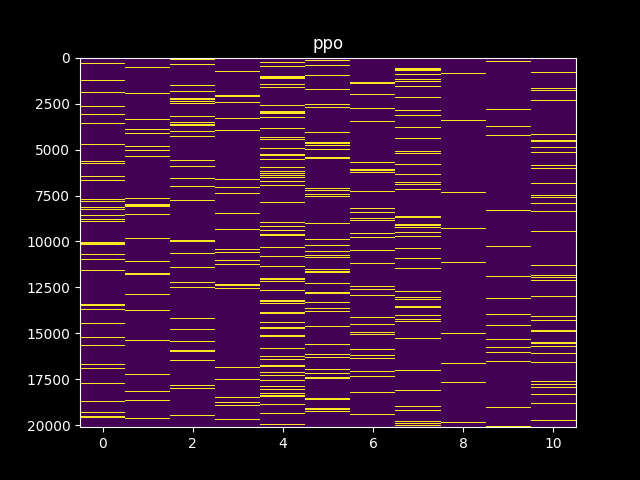

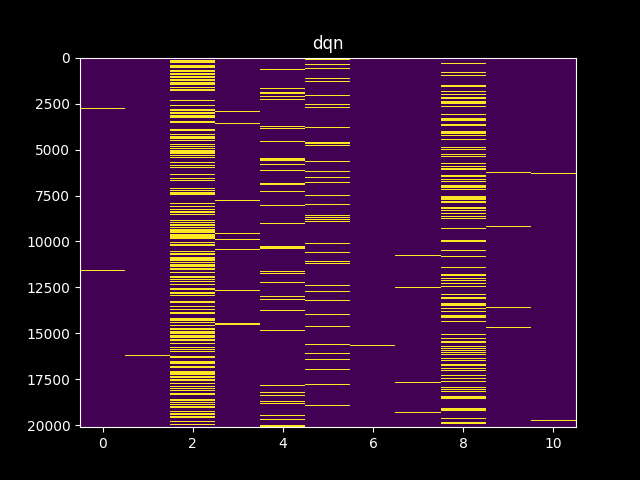

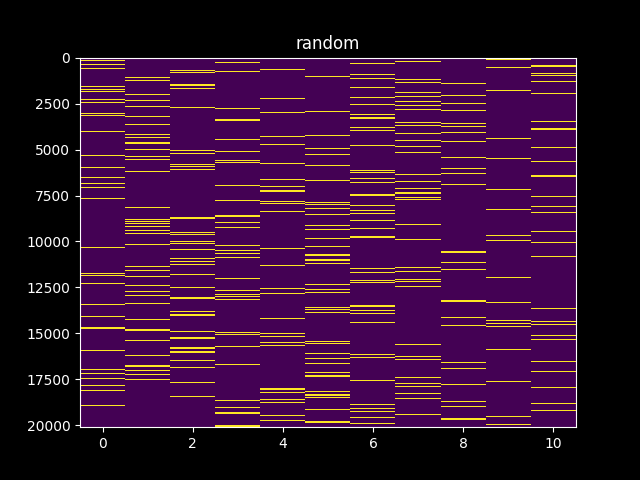

In [55]:
from keras.utils.np_utils import to_categorical
for policy_name, stats in results.items():
    plt.figure()
    plt.title(policy_name)
    plt.imshow(to_categorical(stats["actions"], num_classes=env.action_space.n), interpolation="nearest", aspect="auto")
    plt.show()

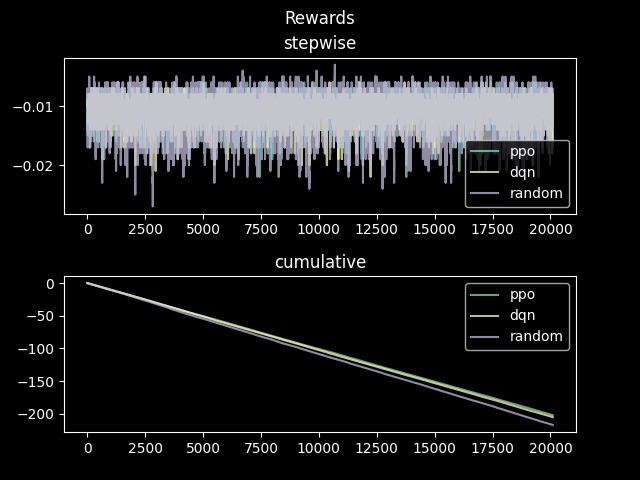

In [56]:
fig, axs = plt.subplots(2)
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.88,
    # wspace=0.4,
    hspace=0.4,
)
fig.suptitle("Rewards")

axs[0].set_title("stepwise")
for policy_name, stats in results.items():
    axs[0].plot(stats["rewards"], label=policy_name, alpha=0.75)
axs[0].legend()


axs[1].set_title("cumulative")
for policy_name, stats in results.items():
    axs[1].plot(np.cumsum(stats["rewards"]), label=policy_name, alpha=0.75)
axs[1].legend()

plt.show()

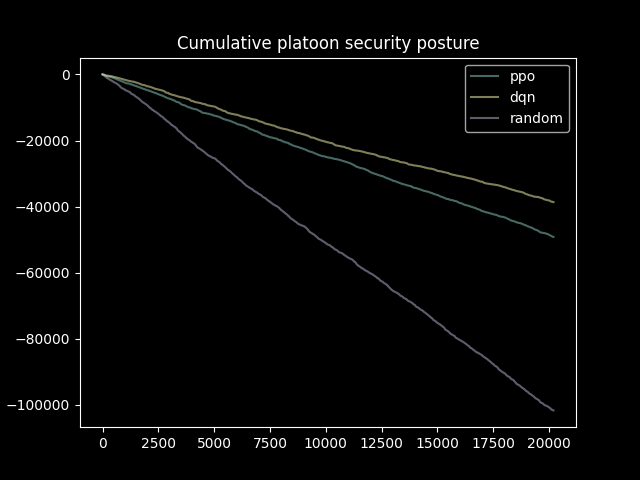

In [57]:
num_vehicles = env.num_vehicles
def measure(obs, info):
    membership = obs[:num_vehicles]
    values = obs[num_vehicles:num_vehicles*2]
    probs = obs[num_vehicles*2:num_vehicles*3]
    try:
        probs = info["probs"]
    except KeyError:
        pass

    # membership = info["state"]
    # values = info["values"]
    
    return np.sum(membership * values * probs)
    
plt.figure()
plt.title("Cumulative platoon security posture")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name, alpha=0.5)
plt.legend()
plt.show()

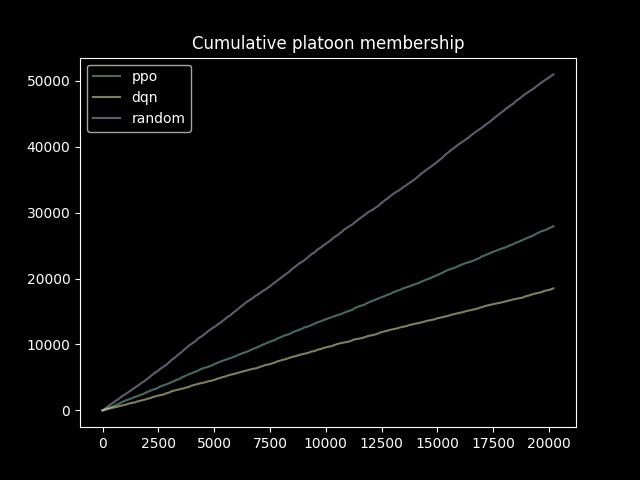

In [58]:
num_vehicles = env.num_vehicles
def measure(obs, info):
    membership = obs[:num_vehicles]
    
    return np.sum(membership)

plt.figure()
plt.title("Cumulative platoon membership")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name, alpha=0.5)
plt.legend()
plt.show()

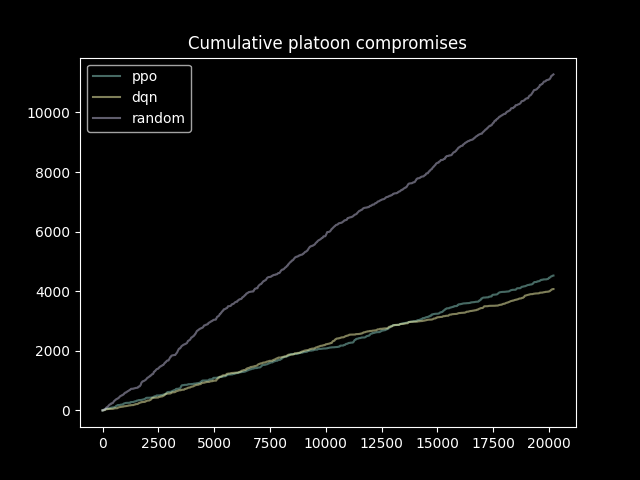

In [59]:
num_vehicles = env.num_vehicles
def measure(obs, info):
    membership = obs[:num_vehicles]
    values = obs[num_vehicles:num_vehicles*2]
    probs = obs[num_vehicles*2:num_vehicles*3]

    return np.sum(membership * (probs == 1))

plt.figure()
plt.title("Cumulative platoon compromises")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name, alpha=0.5)
plt.legend()
plt.show()

In [60]:
totals = [sum(stats["rewards"]) for stats in results.values()]
best = max(totals)
for (policy_name, stats), total in zip(results.items(), totals):
    steps = env_config["steps_before_truncation"]
    pct = (best-total)/best*100
    print(f"{policy_name}: {total:.2f} ({pct:.2f}%)")

ppo: -202.32 (-0.00%)
dqn: -205.26 (-1.45%)
random: -217.25 (-7.38%)
